In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import time
import h5py

import dedalus.public as de
from dedalus.extras import flow_tools

import logging
logger = logging.getLogger(__name__)

In [ ]:
INPUT PARAMETERS

In [3]:
# Input parameters from Barenghi (1991)
eta = 1./1.444 # R1/R2
alpha = 3.13   # vertical wavenumber
Re = 80.       # in units of R1*Omega1*delta/nu
mu = 0.        # Omega2/Omega1

# Computed quantitites
omega_in = 1.
omega_out = mu * omega_in
r_in = eta/(1. - eta)
r_out = 1./(1. - eta)
height = 2.*np.pi/alpha
v_l = 1. # by default, we set v_l to 1.
v_r = omega_out*r_out

In [ ]:
PROBLEM DOMAIN

In [4]:
# Create bases
r_basis = de.Chebyshev('r', 32, interval=(r_in, r_out), dealias=3/2)
z_basis = de.Fourier('z', 32, interval=(0., height), dealias=3/2)
domain = de.Domain([z_basis, r_basis], grid_dtype=np.float64)

In [ ]:
EQUATIONS

In [5]:
TC = de.IVP(domain, variables=['p', 'u', 'v', 'w', 'ur', 'vr', 'wr'], ncc_cutoff=1e-8)
TC.parameters['nu'] = 1./Re
TC.parameters['v_l'] = v_l
TC.parameters['v_r'] = v_r
mu = TC.parameters['v_r']/TC.parameters['v_l'] * eta

In [6]:
TC.add_equation("r*ur + u + r*dz(w) = 0")
TC.add_equation("r*r*dt(u) - r*r*nu*dr(ur) - r*nu*ur - r*r*nu*dz(dz(u)) + nu*u + r*r*dr(p) = -r*r*u*ur - r*r*w*dz(u) + r*v*v")
TC.add_equation("r*r*dt(v) - r*r*nu*dr(vr) - r*nu*vr - r*r*nu*dz(dz(v)) + nu*v  = -r*r*u*vr - r*r*w*dz(v) - r*u*v")
TC.add_equation("r*dt(w) - r*nu*dr(wr) - nu*wr - r*nu*dz(dz(w)) + r*dz(p) = -r*u*wr - r*w*dz(w)")
TC.add_equation("ur - dr(u) = 0")
TC.add_equation("vr - dr(v) = 0")
TC.add_equation("wr - dr(w) = 0")

In [ ]:
INITIAL AND BOUNDARY CONDITIONS

In [8]:
r = domain.grid(1, scales=domain.dealias)
z = domain.grid(0, scales=domain.dealias)

p_analytic = (eta/(1-eta**2))**2 * (-1./(2*r**2*(1-eta)**2) -2*np.log(r) +0.5*r**2 * (1.-eta)**2)
v_analytic = eta/(1-eta**2) * ((1. - mu)/(r*(1-eta)) - r * (1.-eta) * (1 - mu/eta**2))

In [9]:
# boundary conditions
TC.add_bc("left(u) = 0")
TC.add_bc("left(v) = v_l")
TC.add_bc("left(w) = 0")
TC.add_bc("right(u) = 0", condition="nz != 0")
TC.add_bc("right(v) = v_r")
TC.add_bc("right(w) = 0")
TC.add_bc("left(p) = 0", condition="nz == 0")

In [ ]:
TIMESTEPPING

In [10]:
dt = max_dt = 1.
omega1 = TC.parameters['v_l']/r_in
period = 2*np.pi/omega1

ts = de.timesteppers.RK443
IVP = TC.build_solver(ts)
IVP.stop_sim_time = 15.*period
IVP.stop_wall_time = np.inf
IVP.stop_iteration = 10000000

2021-08-19 20:37:48,157 pencil 0/1 INFO :: Building pencil matrix 1/16 (~6%) Elapsed: 0s, Remaining: 1s, Rate: 2.7e+01/s
2021-08-19 20:37:48,204 pencil 0/1 INFO :: Building pencil matrix 2/16 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 2.4e+01/s
2021-08-19 20:37:48,285 pencil 0/1 INFO :: Building pencil matrix 4/16 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2021-08-19 20:37:48,365 pencil 0/1 INFO :: Building pencil matrix 6/16 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2021-08-19 20:37:48,445 pencil 0/1 INFO :: Building pencil matrix 8/16 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2021-08-19 20:37:48,530 pencil 0/1 INFO :: Building pencil matrix 10/16 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2021-08-19 20:37:48,619 pencil 0/1 INFO :: Building pencil matrix 12/16 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2021-08-19 20:37:48,696 pencil 0/1 INFO :: Building pencil matrix 14/16 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 2.4e+01/s
2021-08-19 20:37:48,77

In [ ]:
INITIALIZING STATE VECTORS AND ADDING PERTUBATIONS

In [11]:
p = IVP.state['p']
u = IVP.state['u']
v = IVP.state['v']
w = IVP.state['w']
ur = IVP.state['ur']
vr = IVP.state['vr']
wr = IVP.state['wr']

In [12]:
phi = domain.new_field(name='phi')

In [13]:
for f in [phi,p,u,v,w,ur,vr,wr]:
    f.set_scales(domain.dealias, keep_data=False)

In [14]:
v['g'] = v_analytic
# p['g'] = p_analytic

v.differentiate('r',out=vr)


<Field 139872170865608>

In [15]:
def filter_field(field,frac=0.5):
    dom = field.domain
    local_slice = dom.dist.coeff_layout.slices(scales=dom.dealias)
    coeff = []
    for i in range(dom.dim)[::-1]:
        coeff.append(np.linspace(0,1,dom.global_coeff_shape[i],endpoint=False))
    cc = np.meshgrid(*coeff)

    field_filter = np.zeros(dom.local_coeff_shape,dtype='bool')
    for i in range(dom.dim):
        field_filter = field_filter | (cc[i][local_slice] > frac)
    field['c'][field_filter] = 0j

In [16]:
# incompressible perturbation, arbitrary vorticity
# u = -dz(phi)
# w = dr(phi) + phi/r

phi['g'] = 1e-3* np.random.randn(*v['g'].shape)*np.sin(np.pi*(r - r_in))
filter_field(phi)
phi.differentiate('z',out=u)
u['g'] *= -1
phi.differentiate('r',out=w)
w['g'] += phi['g']/r

u.differentiate('r',out=ur)
w.differentiate('r',out=wr)


<Field 139872170866448>

In [17]:
divu0 = domain.new_field(name='divu0')
u.differentiate('r',out=divu0)
divu0['g'] += u['g']/r + w.differentiate('z')['g']

/home/atharvajoshi/miniconda3/envs/dedalus-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


Text(0, 0.5, 'z')

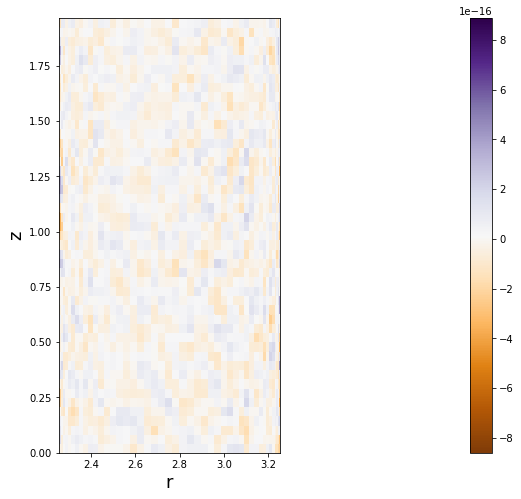

In [18]:
figsize(12,8)
pcolormesh((r[0]*ones_like(z)).T,(z*ones_like(r)).T,divu0['g'].T,cmap='PuOr')
colorbar()
axis('image')
xlabel('r', fontsize=18)
ylabel('z', fontsize=18)

In [ ]:
TIME STEPPING SIZE AND CFL CONDITION

In [19]:
CFL = flow_tools.CFL(IVP, initial_dt=1e-3, cadence=5, safety=0.3,
                     max_change=1.5, min_change=0.5)
CFL.add_velocities(('u', 'w'))

In [ ]:
ANALYSIS

In [20]:
# Integrated energy every 10 iterations.
analysis1 = IVP.evaluator.add_file_handler("scalar_data", iter=10)
analysis1.add_task("integ(0.5 * (u*u + v*v + w*w))", name="total kinetic energy")
analysis1.add_task("integ(0.5 * (u*u + w*w))", name="meridional kinetic energy")
analysis1.add_task("integ((u*u)**0.5)", name='u_rms')
analysis1.add_task("integ((w*w)**0.5)", name='w_rms')

# Snapshots every half an inner rotation period.
analysis2 = IVP.evaluator.add_file_handler('snapshots',sim_dt=0.5*period, max_size=2**30)
analysis2.add_system(IVP.state, layout='g')

# Radial profiles every 100 timesteps.
analysis3 = IVP.evaluator.add_file_handler("radial_profiles", iter=100)
analysis3.add_task("integ(r*v, 'z')", name='Angular Momentum')

In [ ]:
MAIN LOOP

In [21]:
dt = CFL.compute_dt()
# Main loop
start_time = time.time()

while IVP.ok:
    IVP.step(dt)
    if IVP.iteration % 10 == 0:
        logger.info('Iteration: %i, Time: %e, dt: %e' %(IVP.iteration, IVP.sim_time, dt))
    dt = CFL.compute_dt()


end_time = time.time()

# Print statistics
logger.info('Total time: %f' %(end_time-start_time))
logger.info('Iterations: %i' %IVP.iteration)
logger.info('Average timestep: %f' %(IVP.sim_time/IVP.iteration))

2021-08-19 20:46:19,396 __main__ 0/1 INFO :: Iteration: 10, Time: 1.200000e-02, dt: 1.500000e-03
2021-08-19 20:46:19,814 __main__ 0/1 INFO :: Iteration: 20, Time: 3.825000e-02, dt: 3.375000e-03
2021-08-19 20:46:20,258 __main__ 0/1 INFO :: Iteration: 30, Time: 9.731250e-02, dt: 7.593750e-03
2021-08-19 20:46:20,676 __main__ 0/1 INFO :: Iteration: 40, Time: 2.302031e-01, dt: 1.708594e-02
2021-08-19 20:46:21,078 __main__ 0/1 INFO :: Iteration: 50, Time: 5.292070e-01, dt: 3.844336e-02
2021-08-19 20:46:21,450 __main__ 0/1 INFO :: Iteration: 60, Time: 1.201966e+00, dt: 8.649756e-02
2021-08-19 20:46:21,829 __main__ 0/1 INFO :: Iteration: 70, Time: 2.715673e+00, dt: 1.946195e-01
2021-08-19 20:46:22,203 __main__ 0/1 INFO :: Iteration: 80, Time: 6.121514e+00, dt: 4.378939e-01
2021-08-19 20:46:22,648 __main__ 0/1 INFO :: Iteration: 90, Time: 1.378466e+01, dt: 9.852613e-01
2021-08-19 20:46:22,999 __main__ 0/1 INFO :: Iteration: 100, Time: 3.102673e+01, dt: 2.216838e+00
2021-08-19 20:46:23,397 __mai

In [ ]:
ANALYSIS

/home/atharvajoshi/miniconda3/envs/dedalus-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


Text(0, 0.5, 'z')

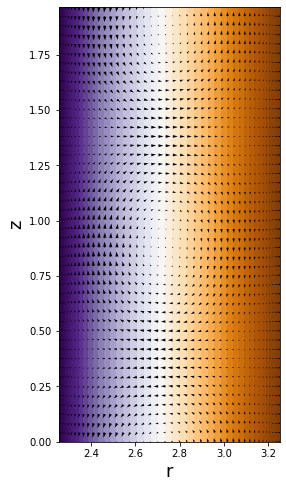

In [23]:
figsize(12,8)
pcolormesh((r[0]*ones_like(z)).T,(z*ones_like(r)).T,v['g'].T,cmap='PuOr')
quiver((r[0]*ones_like(z)).T,(z*ones_like(r)).T,u['g'].T,w['g'].T,width=0.005)
axis('image')
xlabel('r', fontsize=18)
ylabel('z', fontsize=18)

In [24]:
def get_timeseries(data, field):
    data_1d = []
    time = data['scales/sim_time'][:]
    data_out = data['tasks/%s'%field][:,0,0]
    return time, data_out

In [ ]:
READING THE H5 FILES AND GETTING THE DATA

In [25]:
data = h5py.File("scalar_data/scalar_data_s1/scalar_data_s1_p0.h5", "r")
t, ke = get_timeseries(data, 'total kinetic energy')
t, kem = get_timeseries(data, 'meridional kinetic energy')
t, urms = get_timeseries(data, 'u_rms')
t, wrms = get_timeseries(data, 'w_rms')

In [26]:
t_window = (t/period > 2) & (t/period < 14)

gamma_w, log_w0 = np.polyfit(t[t_window], np.log(wrms[t_window]),1)

gamma_w_scaled = gamma_w*Re
gamma_barenghi = 0.430108693
rel_error_barenghi = (gamma_barenghi - gamma_w_scaled)/gamma_barenghi

print("gamma_w = %10.8f" % gamma_w_scaled)
print("relative error = %10.8e" % rel_error_barenghi)

gamma_w = 0.34895183
relative error = 1.88689206e-01


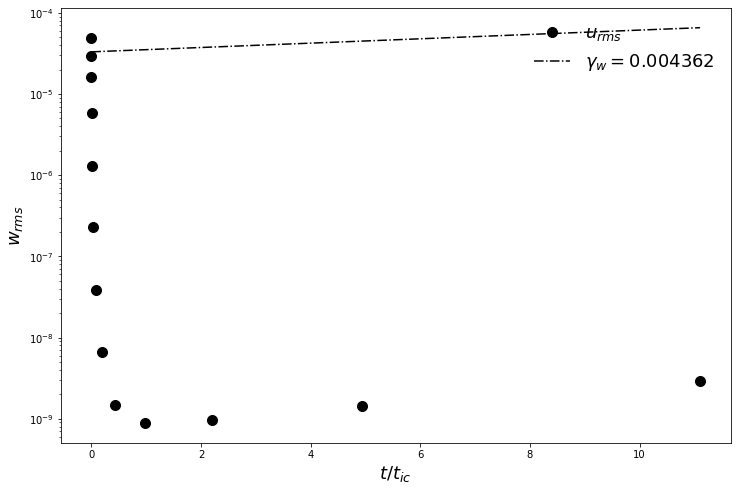

In [42]:
fig = figure()
ax = fig.add_subplot(111)
ax.semilogy(t/period, kem, 'ko', label=r'$u_{rms}$',ms=10)
ax.semilogy(t/period, np.exp(log_w0)*np.exp(gamma_w*t), 'k-.', label='$\gamma_w = %f$' % gamma_w)
ax.legend(loc='upper right',fontsize=18).draw_frame(False)
ax.set_xlabel(r"$t/t_{ic}$",fontsize=18)
ax.set_ylabel(r"$w_{rms}$",fontsize=18)

fig.savefig('growth_rates.png')